In [70]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,make_scorer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
from math import log

sbn.set()

def get_diff_month(d1,d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month




In [82]:
df = pd.read_csv('./data/properties_2016.csv',low_memory=False)
original = df.copy()

train = pd.read_csv('./data/train_2016_v2.csv')

## Dataset Description

The shape of the dataset provided is  (2985217, 58).

The following are the different features of real estate properties that are provided to us: 
1. parcelid
2. airconditioningtypeid
3. architecturalstyletypeid
4. basementsqft
5. bathroomcnt
6. bedroomcnt
7. buildingclasstypeid
8. buildingqualitytypeid
9. calculatedbathnbr
10. decktypeid
11. finishedfloor1squarefeet
12. calculatedfinishedsquarefeet
13. finishedsquarefeet12
14. finishedsquarefeet13
15. finishedsquarefeet15
16. finishedsquarefeet50
17. finishedsquarefeet6
18. fips
19. fireplacecnt
20. fullbathcnt
21. garagecarcnt
22. garagetotalsqft
23. hashottuborspa
24. heatingorsystemtypeid
25. latitude
26. longitude
27. lotsizesquarefeet
28. poolcnt
29. poolsizesum
30. pooltypeid10
31. pooltypeid2
32. pooltypeid7
33. propertycountylandusecode
34. propertylandusetypeid
35. propertyzoningdesc
36. rawcensustractandblock
37. regionidcity
38. regionidcounty
39. regionidneighborhood
40. regionidzip
41. roomcnt
42. storytypeid
43. threequarterbathnbr
44. typeconstructiontypeid
45. unitcnt
46. yardbuildingsqft17
47. yardbuildingsqft26
48. yearbuilt
49. numberofstories
50. fireplaceflag
51. structuretaxvaluedollarcnt
52. taxvaluedollarcnt
53. assessmentyear
54. landtaxvaluedollarcnt
55. taxamount
56. taxdelinquencyflag
57. taxdelinquencyyear
58. censustractandblock

#### The training data has  90275  rows with logerror specified for a parcelid and a transaction date

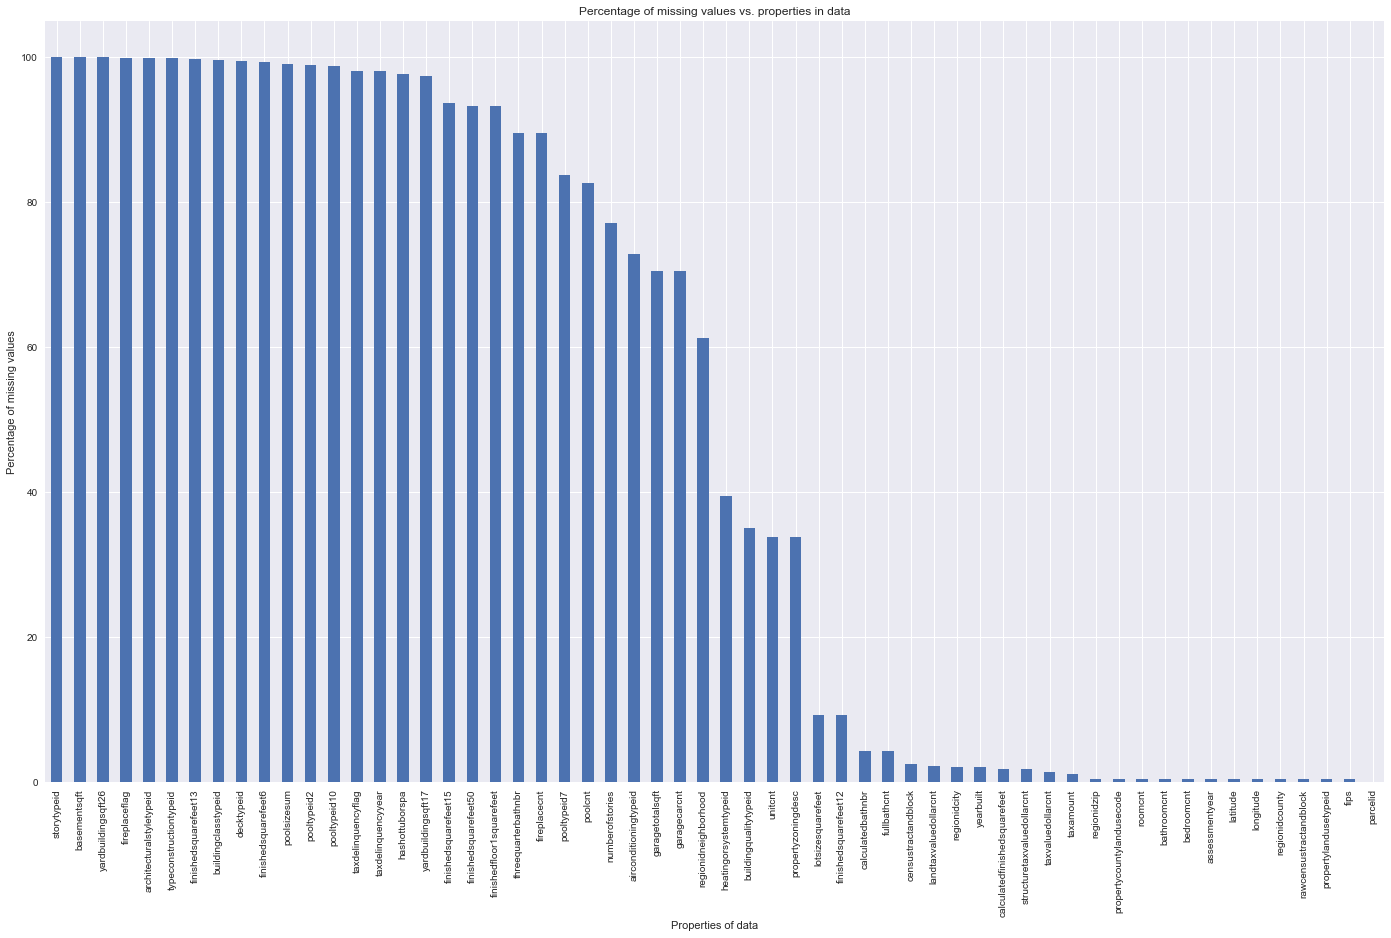

In [8]:
missing_data = original.isnull().sum()
missing_data.sort_values(0,ascending=False,inplace = True)
missing_data = missing_data/(len(original))*100


# missing_data
missing_plot = missing_data.plot.bar(figsize= (24,14))
plt.title('Percentage of missing values vs. properties in data')
plt.xlabel('Properties of data')
plt.ylabel('Percentage of missing values')
plt.savefig('percent.pdf')
plt.show()
del missing_plot
del missing_data

### Identifying Missing Data

We see that **some variables have more than 99% of their data missing**, using these variables for training might add noise to the data and hence adversely affect the training process.

In [152]:
baseline_backup = original.copy()

baseline_backup['yardbuildingsqft17'].fillna(0, inplace = True)
baseline_backup['unitcnt'].fillna(1, inplace = True)
baseline_backup['garagetotalsqft'].fillna(0, inplace = True)
baseline_backup['fireplacecnt'].fillna(0, inplace = True)
baseline_backup['yearbuilt'].fillna(0, inplace = True)
baseline_backup['buildingqualitytypeid'].fillna(0, inplace = True)
baseline_backup['bedroomcnt'].fillna(0, inplace = True)
baseline_backup['lotsizesquarefeet'].fillna(0, inplace = True)
baseline_backup['poolcnt'].fillna(0,inplace = True)
baseline_backup['calculatedbathnbr'].fillna(0,inplace = True)
baseline_backup['airconditioningtypeid'].fillna(0,inplace=True)

#we cant keep object type data to use linear regression, so for the basline model, we drop those columns
baseline_backup.drop(['architecturalstyletypeid','basementsqft', 'buildingclasstypeid', 'decktypeid', 'garagecarcnt',
        'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'roomcnt', 'yardbuildingsqft26', 
         'numberofstories', 'fireplaceflag', 'fullbathcnt', 'heatingorsystemtypeid','storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 
         'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 
         'taxamount', 'bathroomcnt','hashottuborspa','propertycountylandusecode','propertyzoningdesc','taxdelinquencyflag'], axis=1, inplace=True)

### Baseline Cleaning

In this section we perform the most basic form of cleaning on the dataset. We replace missing values with zero in certain columns and drop some columns which are either not very easy to interprete or contain too many missing values. This data will then be used to train the baseline Linear Regression Model.

In [153]:
base_merge = pd.merge(baseline_backup,train,on = 'parcelid')

base_merge.drop('transactiondate',axis=1,inplace=True)
base_merge.fillna(0, inplace=True)  #fill all missing values with 0 in the dataframe


base_logerror = base_merge['logerror']
# invlogerror = [10**i for i in logerror]
base_X_train, base_X_test, base_y_train, base_y_test = train_test_split(base_merge.drop(['logerror','parcelid'],axis=1), base_logerror, test_size=0.2, random_state=42)

base_clf = LinearRegression(n_jobs=-1)
base_clf.fit(base_X_train,base_y_train)

pred = base_clf.predict(base_X_test)
# res = [log(i,10) if i>0 else -log(i*-1,10) for i in res]
print "The MAE for the model is",mean_absolute_error(base_y_test,pred)
print "The MSE for the model is",mean_squared_error(base_y_test,pred)

The MAE for the model is 0.0688988123831
The MSE for the model is 0.0268141196005


### Baseline Model Performance

We use a **Linear Regression** as the baseline model to predict the logerror. The **MSE and MAE are 0.0268 and 0.0688** respectively. These scores aren't impressive but can be used for reference when we are trying to build other models for prediction.

In [154]:
print pd.DataFrame({'columns': list(set(base_merge.keys()) - set(['logerror','parcelid'])),'coeffs': base_clf.coef_}) 

          coeffs                       columns
0   4.252714e-04      finishedfloor1squarefeet
1   8.036962e-04                  regionidcity
2  -7.888249e-04           finishedsquarefeet6
3  -2.282711e-03                   regionidzip
4   5.578462e-06                     yearbuilt
5   1.110089e-05                     longitude
6  -3.809924e-07                  fireplacecnt
7   3.182457e-05                regionidcounty
8  -3.921168e-06               garagetotalsqft
9  -5.346800e-06           censustractandblock
10 -1.642151e-05                       poolcnt
11  6.367620e-03  calculatedfinishedsquarefeet
12 -2.483069e-04            taxdelinquencyyear
13 -1.058907e-05                      latitude
14  8.382458e-10                    bedroomcnt
15  9.737453e-09            yardbuildingsqft17
16  1.607016e-08                       unitcnt
17 -8.092543e-03         buildingqualitytypeid
18  3.081280e-04         propertylandusetypeid
19 -6.126471e-07          regionidneighborhood
20  5.906083e

Based on the coefficients of the feature vectors, *buildingqualitytypeid* was the most influential with the coefficient *-8.092543e-03*. *calculatedfinishedsquarefeet* came in a close second, with the coefficient *6.367620e-03*

In [13]:
del base_X_train
del base_X_test
del base_y_train
del base_y_test

In [ ]:
# df = original.copy()

In [83]:
df['yardbuildingsqft17'].fillna(0, inplace = True)
df['unitcnt'].fillna(1, inplace = True)
df['garagetotalsqft'].fillna(0, inplace = True)
df['fireplacecnt'].fillna(0, inplace = True)
df['hashottuborspa'].fillna(0, inplace = True)
df['yearbuilt'].fillna(df['yearbuilt'].median(), inplace = True)
df['buildingqualitytypeid'].fillna(7, inplace = True) #df['buildingqualitytypeid'].mode() results to 7
df['bedroomcnt'].fillna(df['bedroomcnt'].median(), inplace = True)
df['lotsizesquarefeet'].fillna(df['lotsizesquarefeet'].median(), inplace = True)
df['poolcnt'].fillna(0,inplace = True)
df['calculatedbathnbr'].fillna(df['calculatedbathnbr'].median(),inplace = True)
df['airconditioningtypeid'].fillna(-1,inplace=True)  #earlier it was replaced with 0,now replacing it with -1
df['propertylandusetypeid'].fillna(df['propertylandusetypeid'].mode(),inplace=True)
df['regionidcity'].fillna(df['regionidcity'].mean(),inplace=True) #mean is meaningless, but still
df['taxdelinquencyflag'].fillna(0,inplace=True)
df['taxdelinquencyflag'] =  df['taxdelinquencyflag'].map({'Y':1,0:0})
df['garagecarcnt'].fillna(0,inplace=True)
df['taxdelinquencyyear'] = pd.Series([15-i if i<16 else 115-i for i in df['taxdelinquencyyear']]).fillna(-1)
df['heatingorsystemtypeid'].fillna(2,inplace=True) # df['heatingorsystemtypeid'].mode() results in 2
df['actual_area'] = df[['finishedfloor1squarefeet','calculatedfinishedsquarefeet','finishedsquarefeet12', 'finishedsquarefeet13',
                        'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6']].max(axis=1)

###doing this for now, change later if time permits

df['fips'].fillna(df['fips'].median(),inplace = True)
df['latitude'].fillna(df['latitude'].median(),inplace = True)
df['longitude'].fillna(df['longitude'].median(),inplace = True)
df['regionidcounty'].fillna(df['regionidcounty'].median(),inplace = True)
df['regionidzip'].fillna(df['regionidzip'].median(),inplace = True)

df['actual_area'].replace(to_replace=1.0,value=np.nan,inplace=True)
df['actual_area'].fillna(df['actual_area'].median(),inplace=True)

####

df['hashottuborspa'] = df['hashottuborspa'].map({True:1,0:0})

df['calculatedvalue'] = df[['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']].sum(axis=1)

In [84]:
age = []
for i in df['yearbuilt']:
    age.append(int(2015-i))

df['age'] = age
df.drop(['yearbuilt'],axis=1,inplace=True)

## Feature engineering and Imputation of missing data

#### We list down the different operations we perform on various columns and the reason for it

<table>
  <tr>
    <th>Sr. no.</th>  
    <th>Feature</th>
    <th>Imputation of Missing values</th>
    <th>Reasoning</th>
  </tr>
  <tr>
    <td>1.</td>
    <td>yardbuildingsqft17</td>
    <td>Replace with 0</td>
    <td>The area of 0 will imply that the property doesn't have a yard</td>
  </tr>
  <tr>
    <td>2.</td>  
    <td>unitcnt</td>
    <td>replace with 1</td>
    <td>Minimum a property would have at least one unit. 1,700,000 values were already set to 1 </td>
  </tr>
  <tr>
    <td>4.</td>  
    <td>garagetotalsqft</td>
    <td>replace with 0</td>
    <td>0 implies the property doesn't come with a personal garage space</td>
  </tr>
  <tr>
    <td>5.</td>  
    <td>fireplacecnt</td>
    <td>replace with 0</td>
    <td>0 indicates no fire place</td>
  </tr>
  <tr>
    <td>6.</td>  
    <td>hashottuborspa</td>
    <td>replace with 0</td>
    <td>0 indicates no hot tub</td>
  </tr>
  <tr>
    <td>7.</td>  
    <td>yearbuilt</td>
    <td>replace with median</td>
    <td>Both the median and the mean are around 1960s</td>
  </tr>
  <tr>
    <td>3.</td>  
    <td>buildingqualitytypeid</td>
    <td>replace with 7</td>
    <td>7 is the mode of the distribution by a big margin</td>
  </tr>
  <tr>
    <td>8.</td>  
    <td>bedroomcnt</td>
    <td>Replace with median</td>
    <td>Chose median over mean to be robust to outliers with a lot of bedrooms</td>
  </tr>
  <tr>
    <td>9.</td>  
    <td>lotsizesquarefeet</td>
    <td>replace with median</td>
    <td>Chose median over mean to be robust to outliers</td>
  </tr>
  <tr>
    <td>10.</td>  
    <td>poolcnt</td>
    <td>replace with 0</td>
    <td>0 implies no pool</td>
  </tr>
  <tr>
    <td>11.</td>  
    <td>calculatedbathnbr</td>
    <td>replace with median</td>
    <td>Chose median over mean to be robust to outliers</td>
  </tr>
  <tr>
    <td>12.</td>  
    <td>airconditioningtypeid</td>
    <td>-1</td>
    <td>No data about ACs might increase error</td>
  </tr>
  <tr>
    <td>13.</td>  
    <td>propertylandusetypeid</td>
    <td>replace with mode</td>
    <td>categorical value, hence mode</td>
  </tr>
  <tr>
    <td>14.</td>  
    <td>regionidcity</td>
    <td>replace with mean</td>
    <td>no specific reason</td>
  </tr>
  <tr>
    <td>15.</td>  
    <td>taxdelinquencyflag</td>
    <td>Convert to 1s and 0s</td>
    <td>Presence or absence of tax delinquency</td>
  </tr>
  <tr>
    <td>16.</td>  
    <td>garagecarcnt</td>
    <td>replace with 0</td>
    <td>0 implies no garage</td>
  </tr>
  <tr>
    <td>17.</td>  
    <td>taxdelinquencyyear</td>
    <td>replace with no. of years if given, else -1</td>
    <td>no delinquency is better, hence opposite sign</td>
  </tr>
  <tr>
    <td>18.</td>  
    <td>heatingorsystemtypeid</td>
    <td>replace with 2</td>
    <td>2 is central heating ans is the most common one</td>
  </tr>
  <tr>
    <td>19.</td>  
    <td>fips</td>
    <td>replace with median</td>
    <td>trying to get middle value</td>
  </tr>
  <tr>
    <td>20.</td>  
    <td>latitutde</td>
    <td>median</td>
    <td>trying to get middle value</td>
  </tr>
  <tr>
    <td>21.</td>  
    <td>longitude</td>
    <td>median</td>
    <td>trying to get middle value</td>
  </tr>
  <tr>
    <td>22.</td>  
    <td>regionidcounty</td>
    <td>median</td>
    <td>trying to get middle value</td>
  </tr>
  <tr>
    <td>23.</td>  
    <td>regionidzip</td>
    <td>median</td>
    <td>trying to get middle value</td>
  </tr>
</table>


#### New Features generated

1. actual_area: It is the maximum of 'finishedfloor1squarefeet','calculatedfinishedsquarefeet','finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50' and 'finishedsquarefeet6'. A huge amount of entries are missing, so we just choose the maximum of whatever is available.

2. calculated_value: It is the sum of 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt' and 'taxamount' for that particular data point

3. age: It is the age of the building as of 2015. We use yearbuilt to calculate this and then drop yearbuilt

In [85]:
before_drop = df.copy()
print df.shape
df.drop(['architecturalstyletypeid','basementsqft', 'buildingclasstypeid', 'decktypeid',
        'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'roomcnt', 'yardbuildingsqft26', 
         'numberofstories', 'fireplaceflag', 'fullbathcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 
         'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 
         'taxamount', 'bathroomcnt'], axis=1, inplace=True)
df.drop(['finishedfloor1squarefeet','calculatedfinishedsquarefeet','finishedsquarefeet12', 'finishedsquarefeet13',
              'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6'],axis=1, inplace=True)
print df.shape

(2985217, 60)
(2985217, 31)


In [36]:
before_rogue = df.copy()

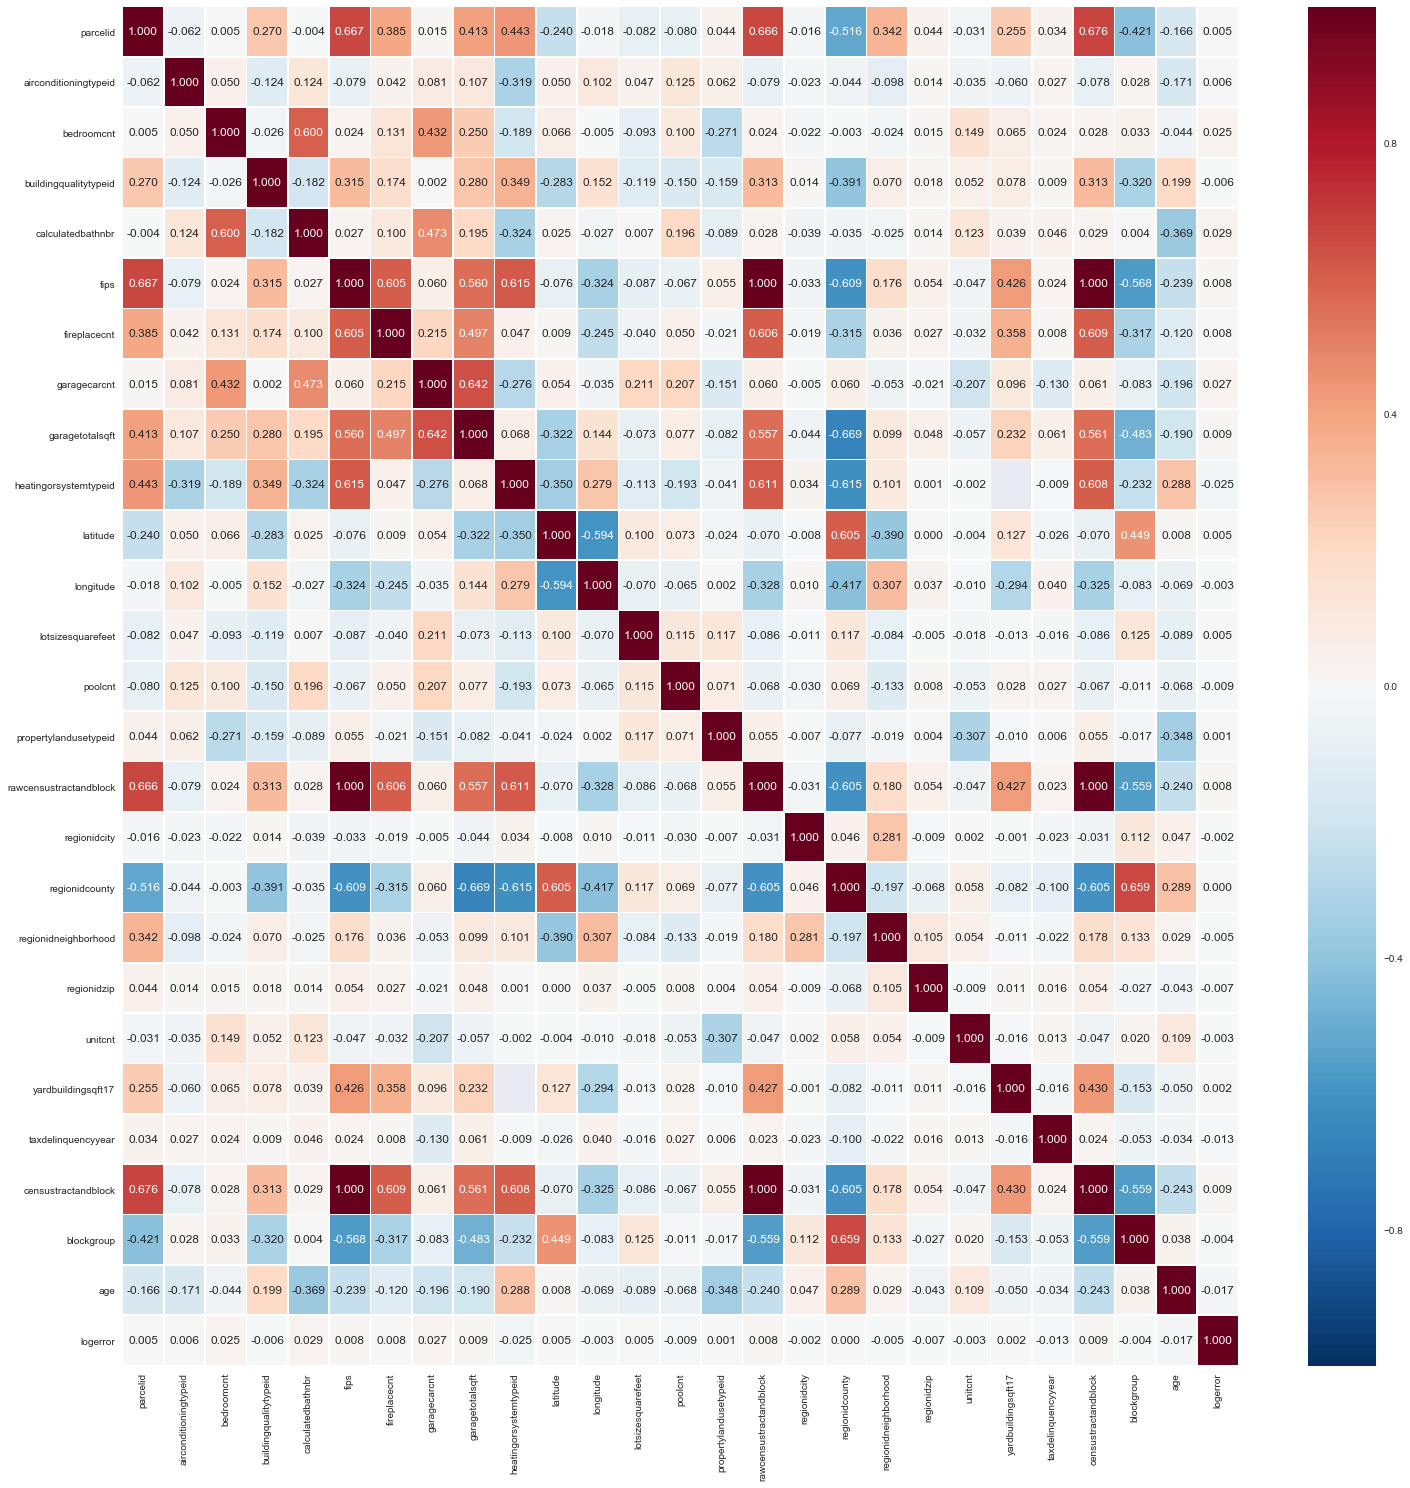

In [37]:
f, ax = plt.subplots(figsize=(25, 25))
temp = pd.merge(before_rogue,train,on='parcelid')
hmap = sbn.heatmap(temp.corr('pearson'), annot=True, fmt=".3f", linewidths=.5, ax=ax)
plt.show()

### Heatmap Observations

**Most of the observations from the heatmap are intuitive and follow general logic**
* bedroomcnt, calculatedbathnbr and actual area are highly correlated with each other
* fips, rawcensustractandblock and censustractandblock, seem to be giving the same data
* regionidcounty is negatively correlated to garagetotalsqft, which is interesting
* actual_area is correlated with calculated_value which is again, intuitive
* calculated_value is slightly negatively correlated to the age of the building
* logerror doesn't show much correlation with any feature, except:
    * actual_area: 0.039
    * calculatedbathnbr: 0.029
    * bedroomcnt: 0.025

Most of the feature correlations with fips, rawcensustractandblock and censustractandblock can be better exploited when we calculate the distance between two properties while predicting the logerror.


In [ ]:
fgure = hmap.get_figure()
fgure.savefig('before_drop_correlation_with_logerror.pdf')

In [86]:
#going rogue

df.drop(['propertycountylandusecode', 'propertyzoningdesc', 'rawcensustractandblock', 'censustractandblock',
         'regionidneighborhood'],axis=1, inplace = True)

Reasons for dropping the above columns:

* propertycountylandusecode has 240 categorical values, so not using it.
* same goes for propertyzoningdesc with too many categorical values
* regionidneighborhood has a lot of null values to fill with no particular obvious strategy


In [102]:

merged = pd.merge(df,train,on = 'parcelid')


In [103]:
dates = []
month = []
for i in merged['transactiondate']:
    dates.append(get_diff_month(datetime.strptime(i,'%Y-%m-%d'),datetime(2015,1,1)))
    month.append(pd.to_datetime(i, format='%Y-%m-%d').month)

# print month

merged['transactiondate'] = dates
merged['month_of_year'] = month


* Transaction date is defined as the number of months since 2015/1/1 after which the transaction was performed.
* We are removing the date information because in the prediction, only the year and month of the transaction are given

*month_of_year* is added as a feature to account for the mean error of prediction in different months of the year (Graph shown in further cells)

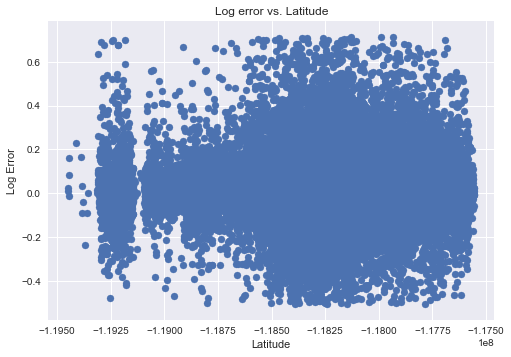

In [212]:
# plt.scatter(logplot.index,logplot.logerror)
plt.scatter(merged.longitude,merged.logerror)
plt.xlabel('Latitude')
plt.ylabel('Log Error')
plt.title("Log error vs. Latitude")
plt.show()

We observe that for lower values of latitude, the Zestimate produces low error. This might indicate if the property is in Ventura (The west most location of the 3 counties), the logerror will be lesser than usual.

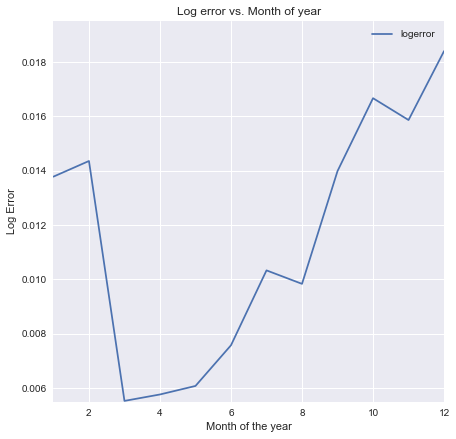

In [159]:
# month_v_error = merge_copy[['month_of_year','logerror']].plot.bar(figsize= (12,7))
month_v_error =  merged[['month_of_year','logerror']].groupby(by='month_of_year').mean().plot.line(figsize= (7,7),
                                                                                                   ylim =[0.0055,0.0195])
plt.title('Log error vs. Month of year')
plt.xlabel('Month of the year')
plt.ylabel('Log Error')
plt.show()

When we plot the month of the year against the mean logerror, we see that the value of the bar graph reduces in the months of March-June before rising up again in July. However, this is not to be intepreted as a reduction in the error, it only means that the mean is lower, the logerror could be negative. We will have to plot the month against the absolute error to see if their model is more accurate during the specified months or does it just give negative error.

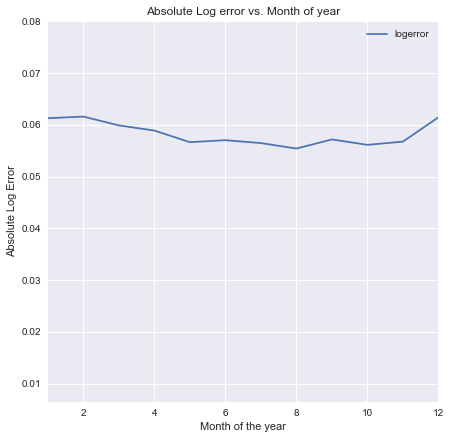

In [160]:
month_v_error = merged[['month_of_year','logerror']].copy()
month_v_error['logerror'] = abs(month_v_error['logerror'])
month_v_error1 =  month_v_error[['month_of_year','logerror']].groupby(by='month_of_year').mean().plot.line(figsize= (7,7),
                                                                                                           ylim = [0.0065,0.08])
plt.title('Absolute Log error vs. Month of year')
plt.xlabel('Month of the year')
plt.ylabel('Absolute Log Error')
plt.show()

As suspected, there is no correlation between the month of the year and the absolute value of logerror. We can still use the value of 'month_of_year' as a feature and see if it benefits the model in anyway.

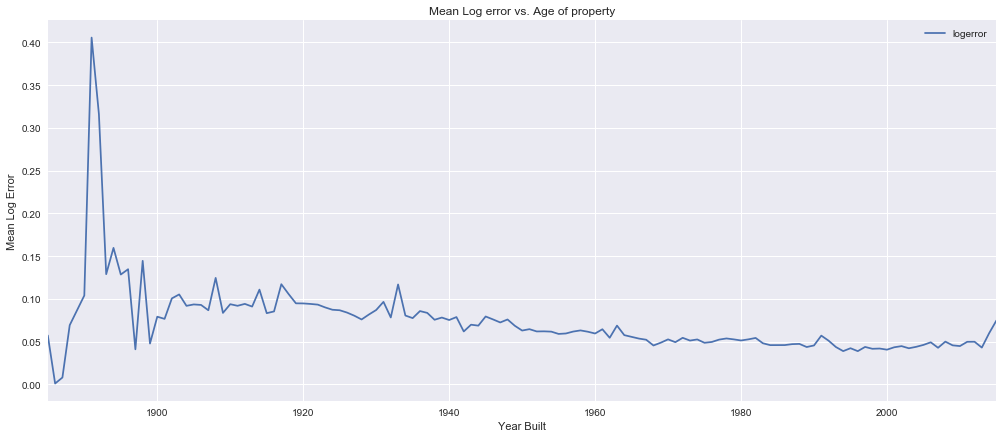

In [162]:
age_v_error = merged[['age','logerror']].copy()
age_v_error['age'] = [2015-i for i in age_v_error['age']]
age_v_error.loc[:,'logerror'] = abs(month_v_error['logerror'])
age_v_error1 =  age_v_error[['age','logerror']].groupby(by='age').mean().plot.line(figsize= (17,7))
plt.xlabel('Year Built')
plt.ylabel('Mean Log Error')
plt.title('Mean Log error vs. Age of property')
plt.show()

We can see that the mean absolute log error shows a reducing trend for properties that were more recently built when compared to the other older ones

In [104]:
# merged.to_csv('./data/merge_copy.csv',index=False)

In [201]:
# merged = pd.read_csv('./data/merge_copy.csv')
merged['regionidcounty'].value_counts(dropna=False)

3101.0    57889
1286.0    24352
2061.0     7132
Name: regionidcounty, dtype: int64

In [179]:
print merged.keys()
print merged.shape

Index([u'parcelid', u'airconditioningtypeid', u'bedroomcnt',
       u'buildingqualitytypeid', u'calculatedbathnbr', u'fips',
       u'fireplacecnt', u'garagetotalsqft', u'hashottuborspa', u'latitude',
       u'longitude', u'lotsizesquarefeet', u'poolcnt', u'regionidcounty',
       u'regionidzip', u'unitcnt', u'yardbuildingsqft17', u'actual_area',
       u'calculatedvalue', u'age', u'logerror', u'transactiondate',
       u'month_of_year'],
      dtype='object')
(89373, 23)


In [177]:
merged = merged[merged['logerror'] <  merged['logerror'].quantile(0.995)]  # exclude outliers
merged = merged[merged['logerror'] >  merged['logerror'].quantile(0.005)]

We remove the points that are on the extreme ends of the spectrum, as they are outliers for our model

In [178]:
merged.drop(['garagecarcnt','heatingorsystemtypeid','propertylandusetypeid','regionidcity',u'taxdelinquencyflag',
             u'taxdelinquencyyear'],axis=1,inplace=True)

In [132]:
logerror = merged['logerror']

X_train, X_test, y_train, y_test = train_test_split(merged.drop(['parcelid','logerror'],axis=1),
                                                    logerror, test_size=0.35, random_state=42)

sc = StandardScaler()
sc_train = sc.fit_transform(X_train)
sc_test = sc.transform(X_test)

In [126]:
clf = LinearRegression(n_jobs=-1,normalize=False)
clf.fit(X_train,y_train)

res = clf.predict(X_test)

print "The MAE is",mean_absolute_error(y_test,res),"and the MSE is",mean_squared_error(y_test,res)

The MAE is 0.057234063948 and the MSE is 0.00933196759458


After imputing missing values and selecting some columns that give us the best result, we again apply linear regression on the data. This time it performs much better and gives an **MAE and MSE of 0.05725 and 0.009327** respectively.

In [127]:
print pd.DataFrame({'columns': list(set(merged.keys()) - set(['logerror','parcelid'])),'coeffs': clf.coef_}) 

          coeffs                columns
0   2.098459e-05  airconditioningtypeid
1  -8.077620e-05        calculatedvalue
2   3.140129e-05              longitude
3  -6.950600e-04  buildingqualitytypeid
4   1.225584e-04                poolcnt
5  -1.758425e-03            actual_area
6  -2.770202e-06                    age
7  -8.292334e-03            regionidzip
8  -4.149567e-09      calculatedbathnbr
9   2.922476e-09          month_of_year
10  1.067703e-08                unitcnt
11 -7.089031e-03                   fips
12  1.623353e-06        garagetotalsqft
13 -3.423522e-08           fireplacecnt
14 -2.229684e-03         regionidcounty
15 -1.504435e-05               latitude
16  9.178209e-06        transactiondate
17 -3.440813e-09      lotsizesquarefeet
18 -2.438842e-05             bedroomcnt
19  2.602041e-04     yardbuildingsqft17
20  2.602041e-04         hashottuborspa


This information will be later used to find out the most important and the weakest attributes that are used for linear regression

The best feature so far in the model is the regionidzip with the coefficient -1.075408e-02 and the weakest feature are both  yardbuildingsqft17 and hashottuborspa with the coefficient -1.274611e+11 and 1.274611e+11 respectively

In [ ]:
# print res.mean(),y_test.mean()
print pd.DataFrame(res).describe(),"\n\n",pd.DataFrame(y_test).describe()

In [ ]:
plt.scatter(res,y_test)
plt.show()

In [128]:
lasso = linear_model.Lasso(alpha = 0.0001,tol=0.000000001,max_iter=2147483647,warm_start = False,normalize=False)
lasso.fit(X_train,y_train)
print mean_absolute_error(lasso.predict(X_test),y_test)

0.0572353990591


In [138]:
svr = svm.LinearSVR(C=0.1, max_iter=20000, tol=1e-06)
svr.fit(sc_train,y_train)

LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=20000,
     random_state=None, tol=1e-06, verbose=0)

In [139]:
print mean_absolute_error(svr.predict(sc_test),y_test), mean_squared_error(svr.predict(sc_test),y_test)

0.0569382865646


LinearSVR has by far given us the **best result** of all the models that were trained. LinearSVR gives an **MAE and MSE of 0.05693 and 0.009327** respectively.

In [ ]:
# knr = KNR(n_jobs=-1)
# knr_param_grid = {
#     'n_neighbors' : [1800,2500,5000],
#     'leaf_size': [200,300,600],
#     'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
    
    
# }
# knr_gcv = GridSearchCV(knr,knr_param_grid,scoring = make_scorer(mean_absolute_error,greater_is_better=False))

# knr_gcv.fit(sc_train,y_train)

# best = knr_gcv.best_estimator_

# print mean_squared_error(best.predict(s_test),y_test), best

The best estimator chosen by the GridSearch was

KNeighborsRegressor(algorithm='auto', leaf_size=300, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1800, p=2,
          weights='uniform')


This gave us an **MAE of 0.056722**




In [150]:
sub = pd.read_csv('./data/sample_submission.csv')

sub.rename(columns={'ParcelId':'parcelid'},inplace=True)
sub_oct = pd.merge(df.drop(['garagecarcnt','heatingorsystemtypeid','propertylandusetypeid','regionidcity',u'taxdelinquencyflag',
                            'taxdelinquencyyear'],axis=1),sub,on='parcelid')

sub_oct.reset_index(inplace=True)
sub_oct.drop(['201610','201611','201612','201710','201711','201712','parcelid',"index"],axis=1,inplace=True)
# sub_oct.info(null_counts=True)


sub_new_dec = sub_oct.copy()
sub_new_nov = sub_oct.copy()
sub_new_oct = sub_oct.copy()
sub_dec = sub_oct.copy()
sub_nov = sub_oct.copy()

sc.fit(merged.drop(['parcelid','logerror'],axis=1))
             
sub_oct['transactiondate'] = [22 for i in range(len(sub_oct))]
sub_oct['month_of_year'] = [10 for i in range(len(sub_oct))]
sub_oct = sc.transform(sub_oct)

sub_nov['transactiondate'] = [23 for i in range(len(sub_oct))]
sub_nov['month_of_year'] = [11 for i in range(len(sub_oct))]
sub_nov = sc.transform(sub_nov)

sub_dec['transactiondate'] = [24 for i in range(len(sub_oct))]
sub_dec['month_of_year'] = [12 for i in range(len(sub_oct))]
sub_dec = sc.transform(sub_dec)

sub_new_oct['transactiondate'] = [34 for i in range(len(sub_oct))]
sub_new_oct['month_of_year'] = [10 for i in range(len(sub_oct))]
sub_new_oct = sc.transform(sub_new_oct)

sub_new_nov['transactiondate'] = [35 for i in range(len(sub_oct))]
sub_new_nov['month_of_year'] = [11 for i in range(len(sub_oct))]
sub_new_nov = sc.transform(sub_new_nov)


sub_new_dec['transactiondate'] = [36 for i in range(len(sub_oct))]
sub_new_dec['month_of_year'] = [12 for i in range(len(sub_oct))]
sub_new_dec = sc.transform(sub_new_dec)

In [145]:
print sub_oct.shape, merged.shape #,"\n\n",merged.keys()

(2985217L, 21L) (89373, 23)


In [194]:
res = sub.copy()

svr = svm.LinearSVR(C=0.1, max_iter=20000, tol=1e-06)
svr.fit(sc.transform(merged.drop(['parcelid','logerror'],axis=1)),logerror)

res['201610'] = svr.predict(sub_oct)
res['201611'] = svr.predict(sub_nov)
res['201612'] = svr.predict(sub_dec)
res['201710'] = svr.predict(sub_new_oct)
res['201711'] = svr.predict(sub_new_nov)
res['201712'] = svr.predict(sub_new_dec)

res.rename(columns={'parcelid':'ParcelId'},inplace=True)
res.to_csv('submission_svr_full.csv',index=False)

ValueError: shapes (2985217,21) and (1,) not aligned: 21 (dim 1) != 1 (dim 0)

In [196]:
sub = pd.read_csv('./data/sample_submission.csv')

sub.rename(columns={'ParcelId':'parcelid'},inplace=True)
cpy = original.copy()
cpy['calculatedfinishedsquarefeet'].fillna(cpy['calculatedfinishedsquarefeet'].mean(),inplace=True)

sub_oct = pd.merge(cpy[['parcelid','calculatedfinishedsquarefeet']],sub,on='parcelid')

sub_oct.reset_index(inplace=True)
sub_oct.drop(['201610','201611','201612','201710','201711','201712','parcelid',"index"],axis=1,inplace=True)
# sub_oct.info(null_counts=True)


sub_new_dec = sub_oct.copy()
sub_new_nov = sub_oct.copy()
sub_new_oct = sub_oct.copy()
sub_dec = sub_oct.copy()
sub_nov = sub_oct.copy()

res = sub.copy()

# svr = svm.LinearSVR(C=0.1, max_iter=20000, tol=1e-06)
# svr.fit(sc.transform(merged.drop(['parcelid','logerror'],axis=1)),logerror)

m = pd.merge(original,train,on='parcelid')
m['calculatedfinishedsquarefeet'].fillna(m['calculatedfinishedsquarefeet'].mean(),inplace=True)

m = m[m['logerror'] <  m['logerror'].quantile(0.995)]  # exclude outliers
m = m[m['logerror'] >  m['logerror'].quantile(0.005)]



lr = LinearRegression(n_jobs=-1)

lr.fit(m['calculatedfinishedsquarefeet'].values.reshape(-1, 1), m['logerror'])

res['201610'] = lr.predict(sub_oct)
res['201611'] = lr.predict(sub_nov)
res['201612'] = lr.predict(sub_dec)
res['201710'] = lr.predict(sub_new_oct)
res['201711'] = lr.predict(sub_new_nov)
res['201712'] = lr.predict(sub_new_dec)

res.rename(columns={'parcelid':'ParcelId'},inplace=True)
res.to_csv('submission_lr_single.csv',index=False)

In [192]:
from sklearn.neural_network import MLPRegressor



mlp = MLPRegressor(learning_rate_init=0.9, activation='relu',hidden_layer_sizes=(50,),learning_rate='invscaling',
                   solver='lbfgs', tol=0.00001, max_iter = 100000)


mlp.fit(sc_train,y_train)

print mean_absolute_error(mlp.predict(sc_test),y_test), mean_absolute_error(mlp.predict(sc_train),y_train)

0.0588817582193 0.057784154357


In [193]:
m = pd.merge(original,train,on='parcelid')
m['calculatedfinishedsquarefeet'].fillna(m['calculatedfinishedsquarefeet'].mean(),inplace=True)

m = m[m['logerror'] <  m['logerror'].quantile(0.995)]  # exclude outliers
m = m[m['logerror'] >  m['logerror'].quantile(0.005)]

lr_train, lr_test, lr_y_train, lr_y_test = train_test_split(m['calculatedfinishedsquarefeet'].values.reshape(-1, 1), m['logerror'], test_size=0.35, random_state=42)


lr = LinearRegression(n_jobs=-1)

lr.fit(lr_train,lr_y_train)

pred = lr.predict(lr_test)
# res = [log(i,10) if i>0 else -log(i*-1,10) for i in res]
print mean_absolute_error(lr_y_test,pred) #, mean_squared_error(base_y_test,pred),base_clf.score(base_X_test,base_y_test)

0.0572752670424
